In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acknowledgment:
# We express our sincere gratitude to the developers and contributors of the
# DGL library, particularly the example implementation of APPNP available at:
# https://github.com/dmlc/dgl/blob/master/examples/sparse/appnp.py
# This work served as a foundational reference and inspiration for our implementation.


In [ ]:
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install dgl==2.4.0+cu121 -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
!pip install --force-reinstall numpy==1.26.4
!pip install lime matplotlib scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: n

In [ ]:
import dgl
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, auc
import numpy as np
import torch.nn as nn
import torch.nn.functional as nnFn
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/snu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
cn_fa_feature_path = "/home/snu/Downloads/Histogram_feature_CN_FA_20bin.npy"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
cn_features = np.array(list(cn_features_dict.values()))

#mci_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Processed_histogram_features_MCI/Histogram_feature_MCI_FA_20bin.npy"
mci_fa_feature_path = "/home/snu/Downloads/Histogram_feature_MCI_FA_20bin.npy"
mci_features_dict = np.load(mci_fa_feature_path, allow_pickle=True).item()
mci_features = np.array(list(mci_features_dict.values()))
cn_labels = np.zeros(cn_features.shape[0])
mci_labels = np.ones(mci_features.shape[0])

In [ ]:
X = np.vstack((cn_features, mci_features))
y = np.hstack((cn_labels, mci_labels))
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_nodes = X.shape[0]
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
alpha = 0.1 # threshold
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)

src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src = src[mask]
dst = dst[mask]

graph = dgl.graph((src.cpu(), dst.cpu()), num_nodes=num_nodes, device='cpu')
graph = dgl.to_bidirected(graph)
graph = dgl.add_self_loop(graph)

graph = graph.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")


Graph Nodes: 300, Edges: 16508, Device: cuda


In [ ]:
# edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
# src, dst = edge_index
# graph = dgl.graph((src, dst))
# graph = dgl.to_bidirected(graph)
# graph = dgl.add_self_loop(graph)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# graph = graph.to(device)
# X_tensor = X_tensor.to(device)
# y_tensor = y_tensor.to(device)

# print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

In [ ]:
class APPNP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=512, dropout=0.2, num_hops=10, alpha=0.2):
        super().__init__()
        self.f_theta = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, out_size),
        )
        self.num_hops = num_hops
        self.A_dropout = nn.Dropout(dropout)
        self.alpha = alpha
        self.loss = self.cut_loss if cut else self.modularity_loss

    def forward(self, A_hat, X):
        Z_0 = Z = self.f_theta(X)
        for _ in range(self.num_hops):
            A_drop = dglsp.val_like(A_hat, self.A_dropout(A_hat.val))
            Z = (1 - self.alpha) * (A_drop @ Z) + self.alpha * Z_0
        return Z

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)
        return (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)
        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        return -(num / den)

In [ ]:
indices = torch.stack(graph.edges())
N = graph.num_nodes()
A = dglsp.spmatrix(indices, shape=(N, N))
I = dglsp.identity(A.shape, device=device)
A_hat = A + I
D_hat = dglsp.diag(A_hat.sum(dim=1)) ** -0.5
A_hat = D_hat @ A_hat @ D_hat

In [ ]:
num_epochs = 5000
lambda_unsup = 5 #0.09
cut = 0

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, log_loss, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np

A_dense = A_hat.to_dense()

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    model = APPNP(in_size=X.shape[1], out_size=2, hidden_size=512, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    ce_loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(A_hat, X_tensor)

        sup_loss = ce_loss(out[train_mask], y_tensor[train_mask])
        unsup_loss = model.cut_loss(A_dense, out) if cut else model.modularity_loss(A_dense, out)
        total_loss = sup_loss + lambda_unsup * unsup_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
            break

        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Sup: {sup_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Total: {total_loss.item():.4f}")


    model.eval()
    with torch.no_grad():
        logits = model(A_hat, X_tensor)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()
    y_pred_test = y_pred[test_mask.cpu().numpy()]
    y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)
    loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
    auc_val = auc(fpr, tpr)


    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_val)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_proba_test)

    print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {auc_val:.4f}")

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")



Training fold 1
Epoch 0 | Sup: 0.6967 | Unsup: -0.1257 | Total: 0.0681
Epoch 500 | Sup: 0.0436 | Unsup: -0.2477 | Total: -1.1950
Epoch 1000 | Sup: 0.0107 | Unsup: -0.2553 | Total: -1.2660
Epoch 1500 | Sup: 0.0067 | Unsup: -0.2578 | Total: -1.2823
Epoch 2000 | Sup: 0.0020 | Unsup: -0.2585 | Total: -1.2905
Epoch 2500 | Sup: 0.0050 | Unsup: -0.2587 | Total: -1.2887
Epoch 3000 | Sup: 0.0008 | Unsup: -0.2589 | Total: -1.2936
Epoch 3500 | Sup: 0.0017 | Unsup: -0.2589 | Total: -1.2926
Epoch 4000 | Sup: 0.0044 | Unsup: -0.2589 | Total: -1.2902
Epoch 4500 | Sup: 0.0015 | Unsup: -0.2594 | Total: -1.2953
Fold 1 | Acc: 0.7704 | Prec: 0.7651 | Rec: 0.8467 | F1: 0.8038 | Loss: 1.9366 | AUC: 0.7959

Training fold 2
Epoch 0 | Sup: 0.6839 | Unsup: -0.1298 | Total: 0.0348
Epoch 500 | Sup: 0.0534 | Unsup: -0.2391 | Total: -1.1422
Epoch 1000 | Sup: 0.0592 | Unsup: -0.2507 | Total: -1.1945
Epoch 1500 | Sup: 0.0033 | Unsup: -0.2500 | Total: -1.2466
Epoch 2000 | Sup: 0.0026 | Unsup: -0.2517 | Total: -1.2558

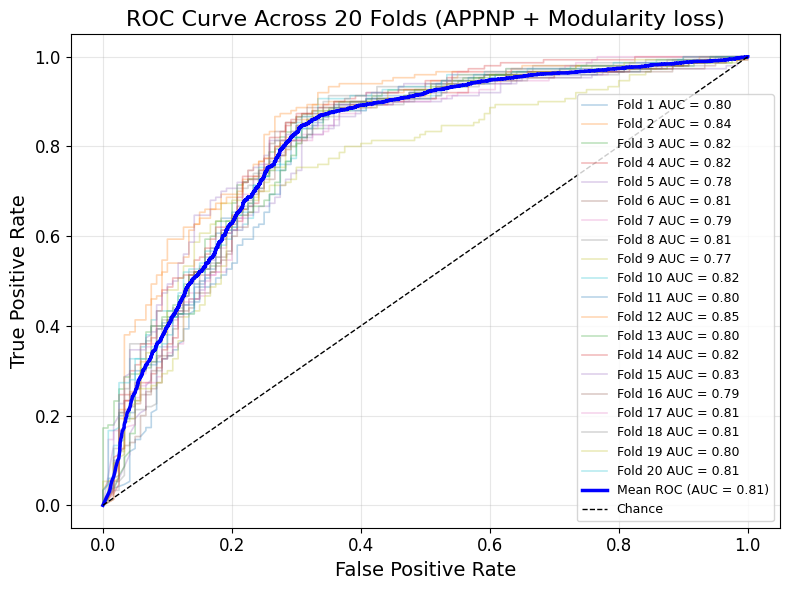

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, lw=1.2, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2.5, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (APPNP + Modularity loss)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

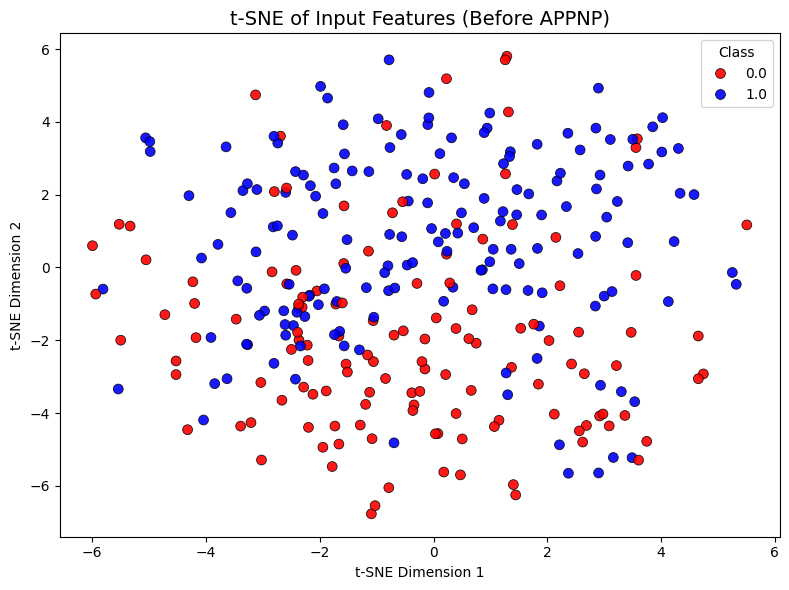

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_np = X_tensor.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_np)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y,
    palette=["red", "blue"],
    s=50,
    alpha=0.9,
    edgecolor='black'
)
plt.title("t-SNE of Input Features (Before APPNP)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class", loc='best')
plt.tight_layout()
plt.show()


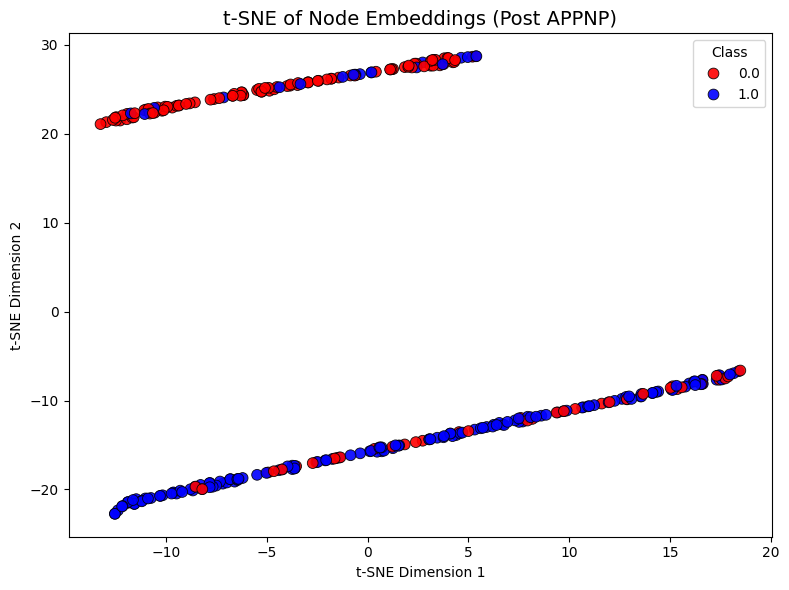

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


model.eval()
with torch.no_grad():
    logits = model(A_hat, X_tensor)
    embeddings = logits.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=y,
    palette=["red", "blue"],
    s=60,
    alpha=0.9,
    edgecolor='black'
)

plt.title("t-SNE of Node Embeddings (Post APPNP)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class", loc='best')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, auc
import numpy as np

num_epochs = 5000
lambda_values = [0.01, 0.09, 0.5, 0.8, 1, 2, 5, 8]
cut = 0
A_dense = A_hat.to_dense()

all_ablation_results = {}

for lambda_unsup in lambda_values:
    print(f"\n========== Running for λ_unsup = {lambda_unsup} ==========\n")

    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

    accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
    all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

    for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
        print(f"\nTraining fold {fold + 1}")

        train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
        test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

        model = APPNP(in_size=X.shape[1], out_size=2, hidden_size=512, dropout=0.2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
        ce_loss = torch.nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(A_hat, X_tensor)

            sup_loss = ce_loss(out[train_mask], y_tensor[train_mask])
            unsup_loss = model.cut_loss(A_dense, out) if cut else model.modularity_loss(A_dense, out)
            total_loss = sup_loss + lambda_unsup * unsup_loss

            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
                break

            total_loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch {epoch} | Sup: {sup_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Total: {total_loss.item():.4f}")

        model.eval()
        with torch.no_grad():
            logits = model(A_hat, X_tensor)
            y_pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

        y_true_test = y_tensor[test_mask].cpu().numpy()
        y_pred_test = y_pred[test_mask.cpu().numpy()]
        y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

        acc = accuracy_score(y_true_test, y_pred_test)
        prec = precision_score(y_true_test, y_pred_test)
        rec = recall_score(y_true_test, y_pred_test)
        f1 = f1_score(y_true_test, y_pred_test)
        loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

        fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
        auc_val = auc(fpr, tpr)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        losses.append(loss_val)
        all_auc.append(auc_val)
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_y_true.extend(y_true_test)
        all_y_proba.extend(y_proba_test)

        print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {auc_val:.4f}")

    all_ablation_results[lambda_unsup] = {
        "Accuracy": (np.mean(accuracies), np.std(accuracies)),
        "Precision": (np.mean(precisions), np.std(precisions)),
        "Recall": (np.mean(recalls), np.std(recalls)),
        "F1 Score": (np.mean(f1_scores), np.std(f1_scores)),
        "Cross-Entropy Loss": (np.mean(losses), np.std(losses)),
        "AUC": (np.mean(all_auc), np.std(all_auc)),
    }

    print(f"\n==== λ_unsup = {lambda_unsup} | Average Results across 20 folds ====")
    print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
    print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")

print("\n========== Final Summary Across All λ_unsup Values ==========\n")
for lmbd, metrics in all_ablation_results.items():
    print(f"λ_unsup = {lmbd}")
    for metric_name, (mean_val, std_val) in metrics.items():
        print(f"{metric_name}: {mean_val:.4f} ± {std_val:.4f}")
    print("-" * 50)



========== Running for λ_unsup = 0.01 ==========


Training fold 1
Epoch 0 | Sup: 0.7217 | Unsup: -0.1281 | Total: 0.7204
Epoch 500 | Sup: 0.0297 | Unsup: -0.1899 | Total: 0.0278
Epoch 1000 | Sup: 0.0062 | Unsup: -0.1951 | Total: 0.0043
Epoch 1500 | Sup: 0.0036 | Unsup: -0.1983 | Total: 0.0016
Epoch 2000 | Sup: 0.0032 | Unsup: -0.1994 | Total: 0.0012
Epoch 2500 | Sup: 0.0029 | Unsup: -0.2016 | Total: 0.0009
Epoch 3000 | Sup: 0.0018 | Unsup: -0.2000 | Total: -0.0002
Epoch 3500 | Sup: 0.0025 | Unsup: -0.2070 | Total: 0.0004
Epoch 4000 | Sup: 0.0021 | Unsup: -0.2048 | Total: 0.0000
Epoch 4500 | Sup: 0.0023 | Unsup: -0.2087 | Total: 0.0002
Fold 1 | Acc: 0.7704 | Prec: 0.7588 | Rec: 0.8600 | F1: 0.8063 | Loss: 0.6929 | AUC: 0.8283

Training fold 2
Epoch 0 | Sup: 0.7014 | Unsup: -0.1251 | Total: 0.7002
Epoch 500 | Sup: 0.0496 | Unsup: -0.1835 | Total: 0.0478
Epoch 1000 | Sup: 0.0088 | Unsup: -0.1973 | Total: 0.0068
Epoch 1500 | Sup: 0.0051 | Unsup: -0.2031 | Total: 0.0031
Epoch 2000 | Sup: 